In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/fractaluser/Downloads/prototype')
from keras.layers import Input, Dense
from keras.models import Model
from keras import callbacks
import time, random
import scipy
import seaborn as sns
sns.set(palette='dark', font_scale = 1)
pd.set_option('display.max_columns', None)
from scipy.spatial import distance

In [62]:
np.random.seed(216)
from tensorflow import set_random_seed

sample_data = pd.read_csv('sample_simulated_transaction_history.csv')
sample_data.date = pd.to_datetime(sample_data.date)

In [63]:
sample_data.head()

,id,date,purchaseamount,dept,category,chain,purchasequantity,company,brand,productsize,productmeasure
0,Donor_1,2015-03-04,203.174075,Sports,Sports,site_1,1,Company1,Brand3,x,xx
1,Donor_1,2016-04-17,300.639489,Sports,Sports,site_1,1,Company1,Brand1,x,xx
2,Donor_1,2015-04-06,374.096413,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand1,x,xx
3,Donor_1,2015-09-04,348.347601,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand3,x,xx
4,Donor_1,2016-03-08,287.477333,Women Apparel,Dresses/Jumpsuits,site_1,1,Company1,Brand3,x,xx


In [64]:
df = sample_data[(sample_data.category == 'Tees & Polos')].reset_index(drop = True)[['id','date', 'purchaseamount']]
df = df.pivot_table(index=['id'], columns='date', values='purchaseamount', aggfunc='mean').fillna(0).T

In [65]:
pre_start_date = '2015-01-01'
pre_end_date = '2015-12-31'

In [66]:
df['dummy_donor_1'] = pd.DataFrame({'dummy_donor_1':df.iloc[:,-1].shift()})
df['dummy_donor_2'] = pd.DataFrame({'dummy_donor_2':df.iloc[:,-2].shift(-1)})
df['dummy_donor_3'] = pd.DataFrame({'dummy_donor_3':df.iloc[:,-3]*1.7})
df = df.fillna(0)

In [67]:
xtrain1 = df[pre_start_date:pre_end_date][df.columns[:5000]].values.T
xtest1 = df[pre_start_date:pre_end_date][df.columns[5000:]].values.T

In [68]:
columns = (xtrain1 == 0).sum(0)
rows = (xtrain1 == 0).sum(1)
print(rows.sum()*100/(xtrain1.shape[0]*xtrain1.shape[1]))

96.51298630136986


In [69]:
columns = (xtest1 == 0).sum(0)
rows = (xtest1 == 0).sum(1)
print(rows.sum()*100/(xtest1.shape[0]*xtest1.shape[1]))

96.52494571081277


In [70]:
DIM = 70

encoding_dim1 = DIM*5
encoding_dim2 = DIM*4
encoding_dim3 = DIM*3
encoding_dim4 = DIM

In [71]:
inputs = Input(shape=(xtrain1.shape[1],))

encoded1 = Dense(encoding_dim1, activation='tanh')(inputs)
encoded2 = Dense(encoding_dim2, activation='tanh')(encoded1)
encoded3 = Dense(encoding_dim3, activation='tanh')(encoded2)
encoded4 = Dense(encoding_dim4, activation='tanh')(encoded3)
decoded1 = Dense(encoding_dim3, activation='tanh')(encoded4)
decoded2 = Dense(encoding_dim2, activation='tanh')(decoded1)
decoded3 = Dense(encoding_dim1, activation='relu')(decoded2)
decoded4 = Dense(xtrain1.shape[1], activation='relu')(decoded3)

autoencoder = Model(inputs, decoded4)
encoder = Model(inputs, encoded4)
hidden_1 = Model(inputs, encoded1)
hidden_2 = Model(inputs, encoded2)
hidden_3 = Model(inputs, encoded3)

In [72]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 365)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 350)               128100    
_________________________________________________________________
dense_10 (Dense)             (None, 280)               98280     
_________________________________________________________________
dense_11 (Dense)             (None, 210)               59010     
_________________________________________________________________
dense_12 (Dense)             (None, 70)                14770     
_________________________________________________________________
dense_13 (Dense)             (None, 210)               14910     
_________________________________________________________________
dense_14 (Dense)             (None, 280)               59080     
__________

In [73]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 365)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 350)               128100    
_________________________________________________________________
dense_10 (Dense)             (None, 280)               98280     
_________________________________________________________________
dense_11 (Dense)             (None, 210)               59010     
_________________________________________________________________
dense_12 (Dense)             (None, 70)                14770     
Total params: 300,160
Trainable params: 300,160
Non-trainable params: 0
_________________________________________________________________


In [74]:
set_random_seed(216)
EPOCHS = 1000
BATCH_SIZE = 500
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(xtrain1, xtrain1, epochs=EPOCHS, verbose = 1, batch_size=BATCH_SIZE, shuffle=True,
                  callbacks = [callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto')], validation_data = (xtest1, xtest1))

Train on 5000 samples, validate on 1003 samples
Epoch 1/1000
5000/5000 [==============================] - 1s 241us/step - loss: 32.4177 - val_loss: 31.6654
Epoch 2/1000
5000/5000 [==============================] - 1s 130us/step - loss: 31.4531 - val_loss: 31.0439
Epoch 3/1000
5000/5000 [==============================] - 1s 130us/step - loss: 30.8007 - val_loss: 30.4113
Epoch 4/1000
5000/5000 [==============================] - 1s 131us/step - loss: 30.0741 - val_loss: 29.6489
Epoch 5/1000
5000/5000 [==============================] - 1s 131us/step - loss: 29.2004 - val_loss: 28.7697
Epoch 6/1000
5000/5000 [==============================] - 1s 130us/step - loss: 28.2395 - val_loss: 27.8858
Epoch 7/1000
5000/5000 [==============================] - 1s 132us/step - loss: 27.2404 - val_loss: 27.0053
Epoch 8/1000
5000/5000 [==============================] - 1s 132us/step - loss: 26.2382 - val_loss: 26.1192
Epoch 9/1000
5000/5000 [==============================] - 1s 132us/step - loss: 25.2372 

5000/5000 [==============================] - 1s 129us/step - loss: 5.4287 - val_loss: 12.3769
Epoch 77/1000
5000/5000 [==============================] - 1s 128us/step - loss: 5.4011 - val_loss: 12.3783
Epoch 78/1000
5000/5000 [==============================] - 1s 127us/step - loss: 5.3587 - val_loss: 12.3859
Epoch 79/1000
5000/5000 [==============================] - 1s 130us/step - loss: 5.3303 - val_loss: 12.4349
Epoch 80/1000
5000/5000 [==============================] - 1s 128us/step - loss: 5.3106 - val_loss: 12.3151
Epoch 81/1000
5000/5000 [==============================] - 1s 128us/step - loss: 5.2702 - val_loss: 12.4117
Epoch 82/1000
5000/5000 [==============================] - 1s 131us/step - loss: 5.2428 - val_loss: 12.3930
Epoch 83/1000
5000/5000 [==============================] - 1s 129us/step - loss: 5.2148 - val_loss: 12.4159
Epoch 84/1000
5000/5000 [==============================] - 1s 128us/step - loss: 5.1853 - val_loss: 12.3657
Epoch 85/1000
5000/5000 [=================

5000/5000 [==============================] - 1s 132us/step - loss: 4.3590 - val_loss: 12.4884
Epoch 152/1000
5000/5000 [==============================] - 1s 128us/step - loss: 4.3521 - val_loss: 12.4787
Epoch 153/1000
5000/5000 [==============================] - 1s 126us/step - loss: 4.3543 - val_loss: 12.4594
Epoch 154/1000
5000/5000 [==============================] - 1s 127us/step - loss: 4.3529 - val_loss: 12.5155
Epoch 155/1000
5000/5000 [==============================] - 1s 130us/step - loss: 4.3499 - val_loss: 12.4903
Epoch 156/1000
5000/5000 [==============================] - 1s 127us/step - loss: 4.3509 - val_loss: 12.4859
Epoch 157/1000
5000/5000 [==============================] - 1s 127us/step - loss: 4.3476 - val_loss: 12.4593
Epoch 158/1000
5000/5000 [==============================] - 1s 129us/step - loss: 4.3489 - val_loss: 12.4461
Epoch 159/1000
5000/5000 [==============================] - 1s 129us/step - loss: 4.3474 - val_loss: 12.4826
Epoch 160/1000
5000/5000 [========

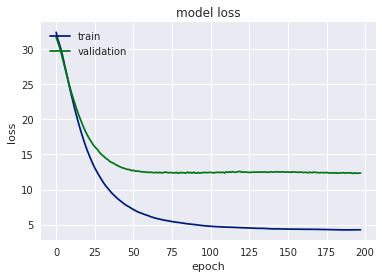

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

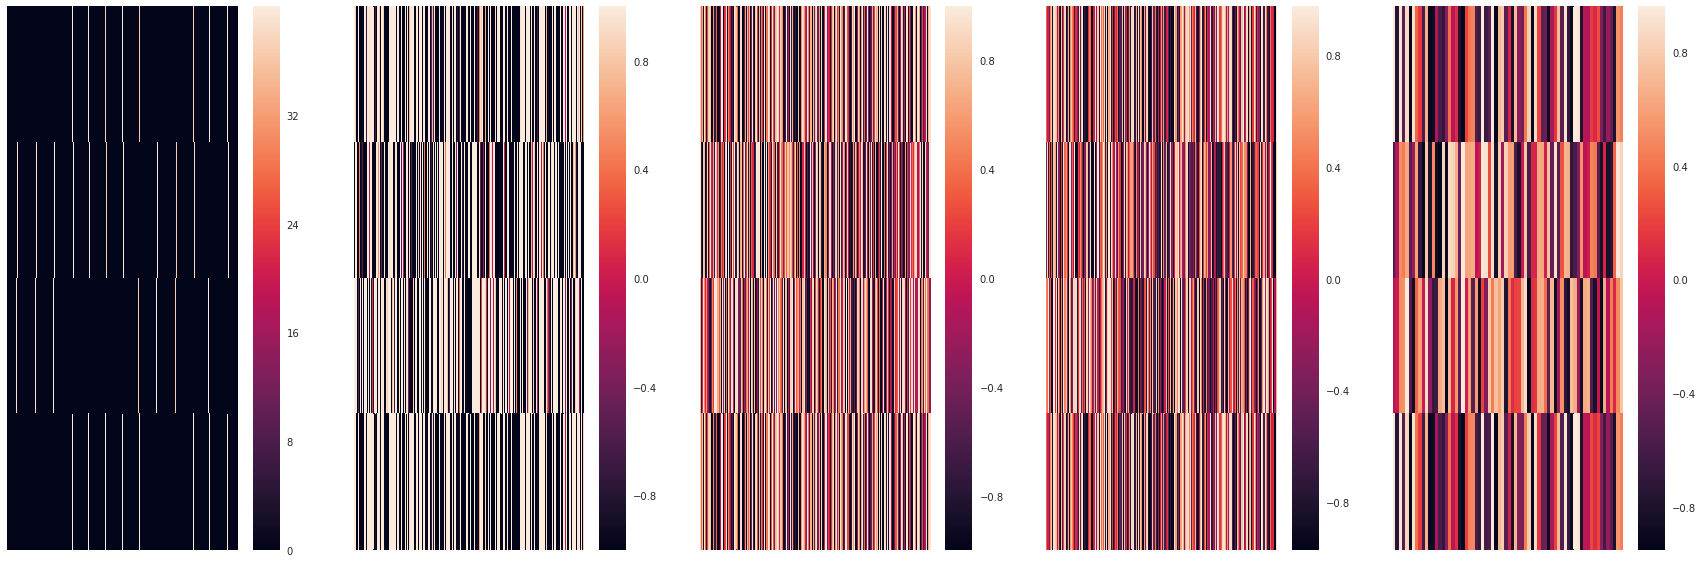

In [76]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, sharey=True, figsize = (30,10))
sns.heatmap(xtest1[-4:], xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax1)
sns.heatmap(hidden_1.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax2)
sns.heatmap(hidden_2.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax3)
sns.heatmap(hidden_3.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax4)
sns.heatmap(encoder.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax5)
plt.show()

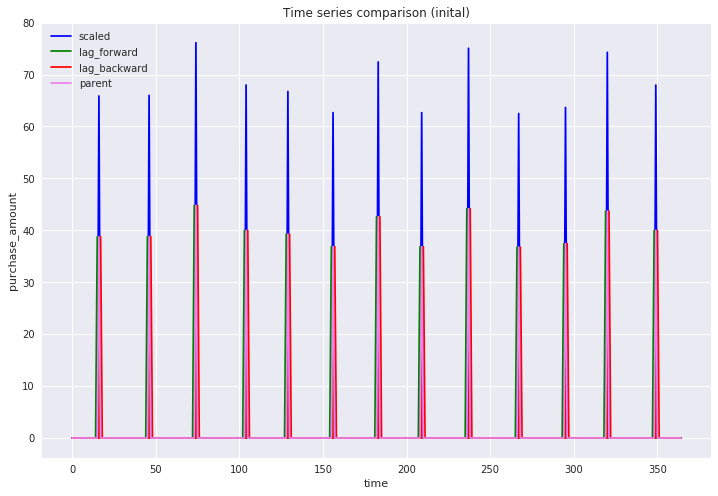

In [77]:
plt.figure(figsize = (12,8))
plt.plot(xtest1[-1], color = 'blue', label = 'scaled')
plt.plot(xtest1[-2], color = 'green', label = 'lag_forward')
plt.plot(xtest1[-3], color = 'red', label = 'lag_backward')
plt.plot(xtest1[-4], color = 'violet', label = 'parent')
plt.title('Time series comparison (inital)')
plt.legend(loc = 'best')
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [78]:
encoded_mat = encoder.predict(xtrain1)
encoded_mat_test = encoder.predict(xtest1)

decoded_mat = autoencoder.predict(xtrain1)
decoded_mat_test = autoencoder.predict(xtest1)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


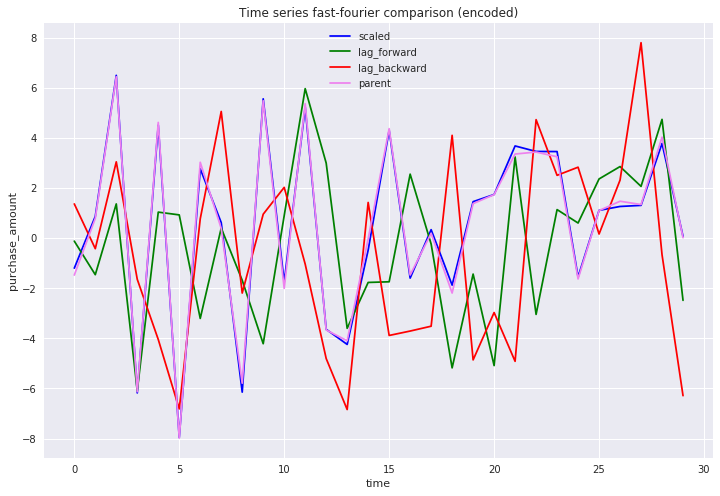

In [79]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(encoded_mat_test[-1])[-30:], color = 'blue', label = 'scaled')
plt.plot(np.fft.fft(encoded_mat_test[-2])[-30:], color = 'green', label = 'lag_forward')
plt.plot(np.fft.fft(encoded_mat_test[-3])[-30:], color = 'red', label = 'lag_backward')
plt.plot(np.fft.fft(encoded_mat_test[-4])[-30:], color = 'violet', label = 'parent')
plt.title('Time series fast-fourier comparison (encoded)')
plt.legend(loc='best')
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [80]:
encoded_df = pd.DataFrame(encoded_mat)
encoded_df.insert(loc=0, column='id', value=df.columns[:5000].values)
encoded_df = encoded_df.set_index(encoded_df.id).drop(labels = ['id'], axis = 1)
encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,-0.876616,0.629124,-0.478706,0.440470,0.035308,-0.818616,0.480479,0.230081,0.984054,0.902790,0.303685,-0.332896,0.504793,-0.220376,0.972799,0.505972,0.539749,-0.102428,-0.340319,0.392937,0.988947,0.652837,-0.600918,-0.452120,0.934485,-0.896980,0.071080,0.824102,0.426123,-0.797934,-0.393284,0.572974,0.553463,0.975335,-0.283749,0.384960,-0.172543,-0.905708,-0.256140,-0.627797,-0.024125,0.586983,0.378506,0.985459,0.943661,-0.017405,0.806855,0.475072,0.870124,0.473882,-0.769857,0.384157,0.604998,-0.512232,0.087961,0.130014,0.200042,0.523000,0.901929,-0.278200,0.594187,-0.044216,-0.377024,-0.245573,-0.762586,-0.917351,0.850909,-0.813232,-0.252400,-0.788517
Donor_100,-0.093106,-0.654593,-0.181553,0.418012,0.514469,0.619683,-0.582656,-0.688643,0.488855,-0.049446,-0.340828,0.342987,-0.911413,0.734416,-0.442383,-0.571826,0.058993,0.778195,-0.867937,-0.118493,0.443397,-0.694339,-0.962337,-0.564119,0.662104,0.376033,0.839872,0.894185,-0.398577,-0.657648,0.342623,0.596729,0.614565,0.081914,0.709927,-0.964037,0.447056,0.398687,-0.744611,0.666882,-0.969075,0.611888,0.906546,-0.984589,0.535473,-0.207198,-0.973796,0.666967,0.160951,-0.947796,-0.806380,0.743453,-0.761795,-0.415259,-0.338748,0.725049,-0.289846,0.407923,-0.309981,0.499801,0.615979,0.863698,0.486386,-0.659399,0.874392,-0.713070,0.339714,-0.062047,-0.529970,0.252451
Donor_1000,-0.537967,-0.064792,0.533326,-0.577843,0.592283,-0.832850,-0.010423,-0.384828,0.693906,0.868442,0.610539,-0.827976,0.968347,0.535682,0.769037,0.816508,-0.887442,0.308279,-0.465858,-0.457545,-0.915608,0.679788,-0.766199,-0.869649,-0.542412,0.439871,0.747226,0.603680,0.668068,0.163789,0.776386,-0.336421,0.269444,0.626785,0.241327,0.976142,-0.791818,-0.354125,-0.636614,0.463898,0.350643,-0.845184,-0.088037,-0.842418,0.894551,0.956039,0.624952,0.715634,-0.767930,-0.130967,-0.447773,0.496085,0.915760,0.625142,-0.269345,0.296450,-0.700689,0.711411,0.354410,0.822493,-0.332156,0.731750,0.218428,-0.494930,-0.571120,-0.870152,0.297901,0.926747,-0.992613,0.683970
Donor_1001,0.091670,-0.548319,-0.898647,-0.680391,-0.236076,0.926942,0.894071,-0.146758,0.800072,-0.562057,-0.945878,-0.913637,0.179007,0.901448,-0.720386,0.404693,-0.280520,-0.447806,-0.603964,0.650869,-0.470598,-0.756277,-0.916121,0.813630,-0.231333,-0.716994,0.930422,0.155673,-0.849241,-0.268608,0.903141,-0.251455,-0.142774,-0.738024,-0.203919,0.362572,0.865337,0.359002,-0.812707,-0.204319,0.387129,0.017723,0.495615,-0.045854,-0.712222,0.751315,0.930179,0.553390,-0.286541,-0.500896,-0.805404,-0.633819,0.632255,-0.594045,-0.055376,-0.478747,-0.837409,0.742573,-0.341175,-0.582020,0.738059,0.090791,0.537608,-0.128950,-0.072473,0.878701,0.289767,-0.487295,-0.622488,0.033812
Donor_1002,0.947827,-0.492563,0.767238,-0.488213,0.505827,0.016947,0.182001,0.814063,-0.854048,-0.945673,-0.802229,-0.780495,0.669140,0.216781,0.023484,-0.228812,0.277511,0.974078,0.895524,0.920894,0.946521,-0.280157,-0.683500,-0.309692,0.236025,0.985279,0.126352,0.366206,0.773546,-0.004763,-0.723034,-0.818835,-0.842246,-0.472186,0.613897,-0.940410,-0.899173,0.498686,0.977365,-0.184915,-0.126059,-0.758467,0.970093,-0.969958,0.813490,-0.641997,-0.440423,0.921515,-0.577983,-0.285796,-0.946113,-0.108518,0.455008,0.696433,0.221845,0.327812,-0.127098,-0.645891,0.107664,-0.145341,-0.963806,0.870270,-0.350462,0.715631,0.394841,-0.003129,0.139450,-0.220776,-0.387888,0.755285


In [81]:
encoded_df_test = pd.DataFrame(encoded_mat_test)
encoded_df_test.insert(loc=0, column='id', value=df.columns[5000:].values)
encoded_df_test = encoded_df_test.set_index(encoded_df_test.id).drop(labels = ['id'], axis = 1)
encoded_df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,-0.849531,-0.941090,0.310772,-0.159678,-0.751225,0.437188,0.501300,-0.456582,-0.923460,0.679103,-0.499588,0.099956,0.555955,0.862871,-0.713915,0.469582,0.731368,-0.953661,0.827380,0.827016,0.875598,0.108355,-0.898771,-0.032738,-0.423711,0.208867,0.629829,-0.928904,-0.878021,-0.967215,0.035593,0.172790,-0.173424,-0.868079,-0.606750,-0.798563,-0.595864,-0.139327,-0.341096,-0.681537,-0.885206,0.271113,0.678390,0.629047,0.888980,-0.192634,-0.712531,0.590408,0.847773,0.355288,0.833709,-0.679436,0.924988,-0.281144,-0.687940,0.289429,0.044354,-0.168967,-0.642204,-0.507961,-0.724718,-0.295703,-0.415845,0.864753,0.665565,-0.473867,0.617015,-0.457030,0.841772,0.023252
Test_145,0.381957,0.004388,-0.590966,-0.840140,-0.610149,0.963645,-0.225094,0.055170,0.464964,-0.542506,-0.768991,-0.586230,-0.557731,0.293698,-0.981877,0.425842,-0.458899,0.871567,-0.315202,0.103534,-0.262109,-0.957717,-0.552287,0.170303,-0.101196,0.465833,-0.323429,0.665016,-0.390052,-0.715176,0.985661,0.133530,0.871251,-0.054457,-0.201006,-0.286006,0.285807,0.222018,0.102200,-0.767382,-0.681075,0.201180,-0.074663,-0.908716,-0.158049,-0.063836,0.419091,-0.826155,-0.839493,-0.814785,-0.048496,-0.168899,-0.875837,0.032370,0.137851,0.040194,-0.833477,0.672578,-0.978134,-0.313827,-0.587550,0.153642,0.979286,0.100293,0.046541,0.308640,0.229315,-0.504790,-0.648012,-0.431162
Test_1450,0.965419,-0.830196,0.889298,-0.337976,-0.641050,-0.846699,0.152935,-0.419813,0.402070,0.449317,0.795935,0.310539,-0.816675,-0.683794,-0.575892,-0.655171,0.238412,-0.595159,-0.035166,0.165634,-0.845451,0.814508,-0.015948,0.725710,0.672208,0.964799,0.550554,0.309155,0.864231,0.375306,0.911202,-0.937093,0.562512,0.621396,-0.442994,0.204921,0.099625,0.449520,0.453947,-0.929550,0.713748,0.158224,-0.518395,0.618726,0.633970,0.795319,-0.404021,0.968397,-0.727560,-0.863879,-0.887420,0.756774,-0.433572,0.463654,0.138435,-0.892617,-0.058154,0.637905,-0.656279,-0.043768,0.670481,-0.051681,-0.871702,-0.668083,-0.284948,-0.234345,-0.238096,-0.880778,0.938829,0.006164
Test_1451,-0.811771,-0.825866,0.503454,-0.488845,0.434474,0.810060,-0.189436,0.810806,-0.410802,-0.439445,0.901247,0.675272,-0.606386,0.569507,0.755477,0.903065,-0.512784,-0.264748,0.784832,-0.436396,0.854979,-0.945096,-0.425231,-0.715402,0.085615,0.648579,-0.153224,-0.448881,0.935356,0.708936,-0.033745,-0.953234,0.257323,0.758930,-0.405343,0.377224,0.624628,0.419852,-0.195741,0.060813,-0.488018,0.345628,-0.119843,0.082769,-0.083690,-0.727356,0.779644,0.922916,-0.322781,-0.161154,-0.754784,0.985628,-0.103405,0.289510,0.479775,-0.884883,-0.500202,0.288184,-0.532257,-0.184713,0.372904,-0.001477,-0.096722,0.965391,0.649853,0.195689,0.659260,0.935013,0.570288,0.537585
Test_1452,-0.872169,-0.764961,-0.307058,-0.379368,0.206423,0.296720,0.752321,0.747109,0.900109,-0.612801,-0.462700,-0.939163,-0.131924,0.144392,-0.114316,-0.098307,-0.889978,0.606517,-0.648693,-0.498016,0.244727,-0.925847,0.827358,-0.961786,-0.524238,-0.097098,0.328276,-0.467957,0.584900,-0.465505,-0.285581,-0.982621,-0.432622,0.787670,0.890266,-0.033205,-0.488693,-0.660304,0.459617,-0.399162,0.733121,0.547319,-0.576281,0.741406,-0.470289,-0.573261,0.895743,-0.811552,-0.554796,0.749065,-0.062041,-0.400218,0.818110,0.914555,0.591015,0.388704,0.842757,0.644444,-0.440710,0.497727,-0.816923,-0.519837,0.732430,0.117501,-0.618794,0.712292,0.739436,0.348264,-0.326998,0.938099


In [82]:
xtrain = pd.DataFrame(xtrain1)
average_initial = xtrain.mean(axis = 0)
xtrain.insert(loc = 0, column = 'id', value = df.columns[:5000].values)
xtrain = xtrain.set_index(xtrain.id).drop(labels = ['id'], axis = 1)
xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.0,0.0,0.0,0.0,0.0,0.0,28.103086,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,25.465567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,29.395883,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.681370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,28.54345,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,28.002926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,27.025801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.822557,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,30.611507,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.675734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.815237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.406283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,29.19701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,32.555135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Donor_100,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,15.523447,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,21.602001,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.930828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,

In [83]:
comparison = pd.DataFrame(decoded_mat)
average_decoded = comparison.mean(axis = 0)
comparison.insert(loc = 0, column = 'id', value = df.columns[:5000].values)
comparison = comparison.set_index(comparison.id).drop(labels = ['id'], axis = 1)
comparison.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.0,0.0,0.0,0.0,0.0,0.0,25.605774,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,21.582762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,23.523516,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.841257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,24.738884,0.0,0.0,1.882007,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.697757,0.0,0.00000,0.0,0.0,0.0,0.0,29.653906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,27.218012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,30.034607,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.424932,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.258232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,21.703093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,34.090984,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Donor_100,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,23.225767,0.0,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.089428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.063499,0.000000,0.0

In [84]:
xtest = pd.DataFrame(xtest1)
average_initial_test = xtest.mean(axis = 0)
xtest.insert(loc = 0, column = 'id', value = df.columns[5000:].values)
xtest = xtest.set_index(xtest.id).drop(labels = ['id'], axis = 1)
xtest.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,34.0962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,27.922484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,32.689643,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,32.538395,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,31.536311,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,31.296507,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,32.473824,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,25.174308,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,27.997594,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,32.697277,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,33.582588,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.953825,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.773184,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.259073
Test_145,0.0,0.0,43.088934,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,43.384996,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,40.449101,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.

In [85]:
comparison_test = pd.DataFrame(decoded_mat_test)
average_decoded_test = comparison_test.mean(axis = 0)
comparison_test.insert(loc = 0, column = 'id', value = df.columns[5000:].values)
comparison_test = comparison_test.set_index(comparison_test.id).drop(labels = ['id'], axis = 1)
comparison_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,30.089531,0.0,0.0,7.982515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,44.299412,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,22.306307,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.401501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,15.354115,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,16.084854,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,18.428528,0.0,0.000000,0.0,0.000000,0.0,0.0,1.240342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,57.217247,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,4.682454,0.0,0.000000,0.000000,0.000000,12.914266,32.345604,0.0,0.0,0.0,0.238822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.033029,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.631603,29.179047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.06618,0.0,0.0,0.0,0.00000,0.0,0.0,30.69039
Test_145,0.0,0.0,8.326123,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,15.660932,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.666318,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.

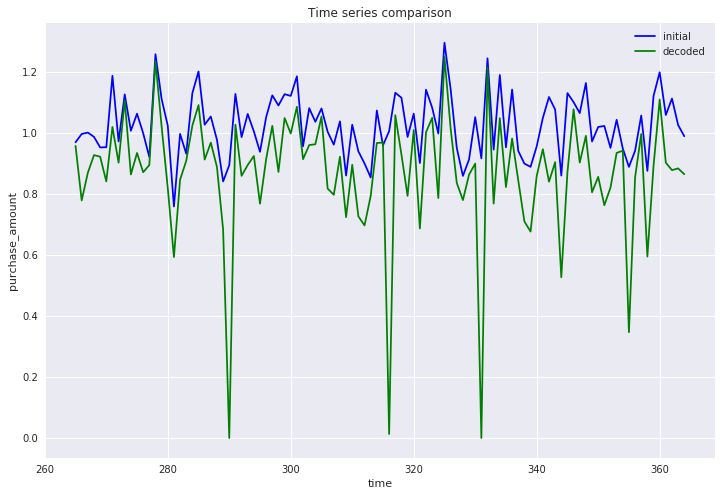

In [86]:
plt.figure(figsize = (12,8))
plt.plot(average_initial[-100:], color = 'blue', label = 'initial')
plt.plot(average_decoded[-100:], color = 'green', label = 'decoded')
plt.title('Time series comparison')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


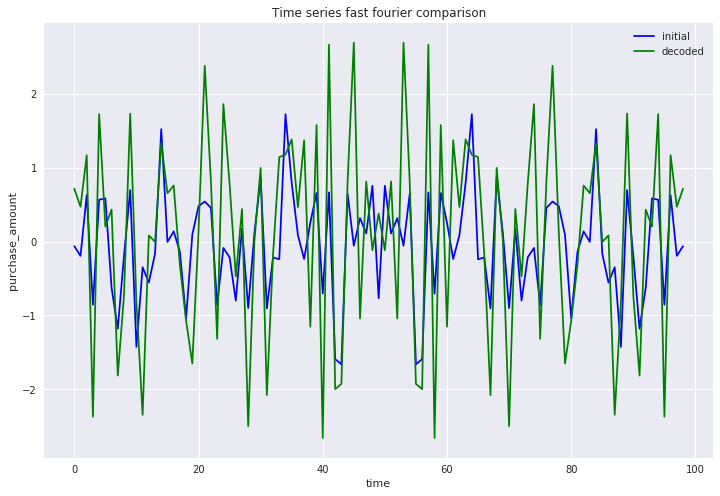

In [87]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(average_initial[-100:])[1:], color = 'blue', label = 'initial')
plt.plot(np.fft.fft(average_decoded[-100:])[1:], color = 'green', label = 'decoded')
plt.title('Time series fast fourier comparison')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

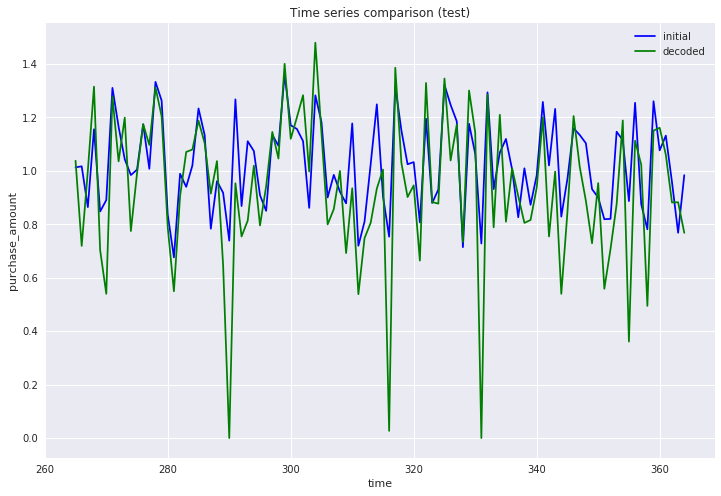

In [88]:
plt.figure(figsize = (12,8))
plt.plot(average_initial_test[-100:], color = 'blue', label = 'initial')
plt.plot(average_decoded_test[-100:], color = 'green', label = 'decoded')
plt.title('Time series comparison (test)')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


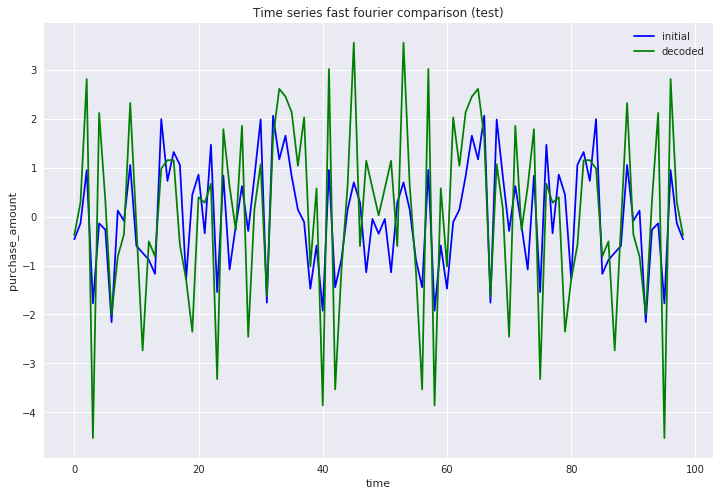

In [89]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(average_initial_test[-100:])[1:], color = 'blue', label = 'initial')
plt.plot(np.fft.fft(average_decoded_test[-100:])[1:], color = 'green', label = 'decoded')
plt.title('Time series fast fourier comparison (test)')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [90]:
binary_xtrain = np.where(xtrain>0, 1, 0)
binary_decoded_mat = np.where(decoded_mat>0,1,0)

binary_xtest = np.where(xtest>0, 1, 0)
binary_decoded_mat_test = np.where(decoded_mat_test>0,1,0)

In [91]:
print('Percent similarity', 100 - (abs(np.linalg.norm(xtrain)-np.linalg.norm(decoded_mat))*100/min(np.linalg.norm(xtrain), np.linalg.norm(decoded_mat))))
print('Percent similarity binary', 100 - (abs(np.linalg.norm(binary_xtrain)-np.linalg.norm(binary_decoded_mat))*100/min(np.linalg.norm(binary_xtrain), np.linalg.norm(binary_decoded_mat))))

Percent similarity 92.69574370423595
Percent similarity binary 97.54345138546621


In [92]:
print('Percent similarity', 100 - (abs(np.linalg.norm(xtest)-np.linalg.norm(decoded_mat_test))*100/min(np.linalg.norm(xtest), np.linalg.norm(decoded_mat_test))))
print('Percent similarity binary', 100 - (abs(np.linalg.norm(binary_xtest)-np.linalg.norm(binary_decoded_mat_test))*100/min(np.linalg.norm(binary_xtest), np.linalg.norm(binary_decoded_mat_test))))

Percent similarity 96.3500233709573
Percent similarity binary 87.9280050382417


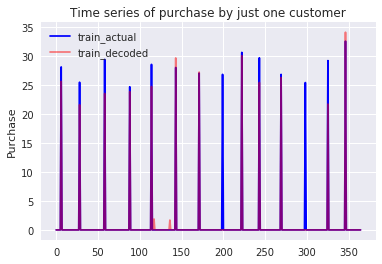

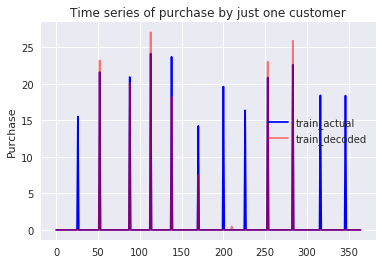

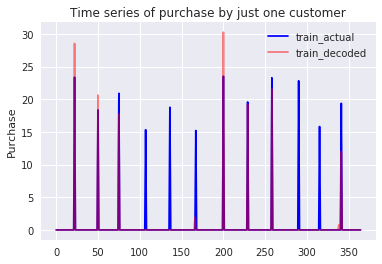

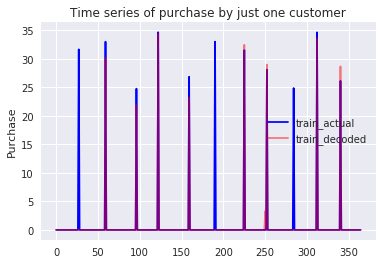

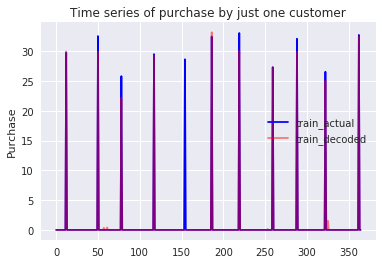

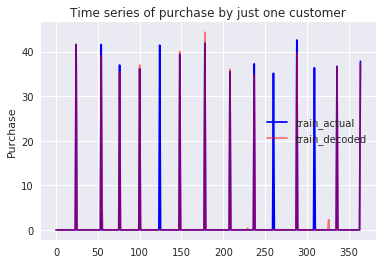

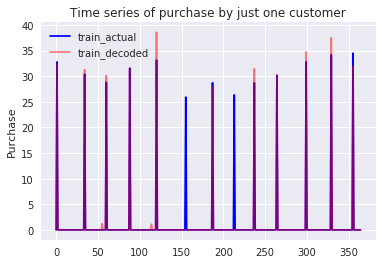

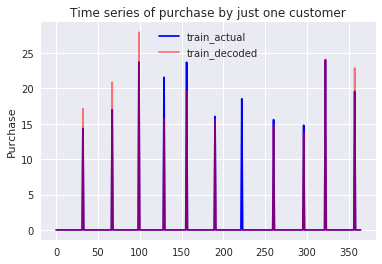

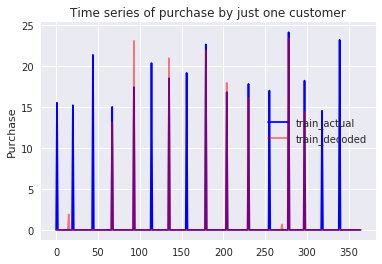

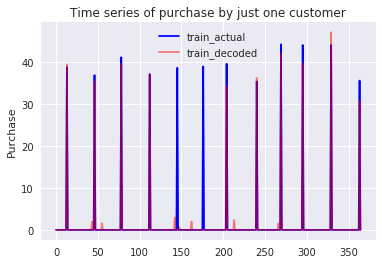

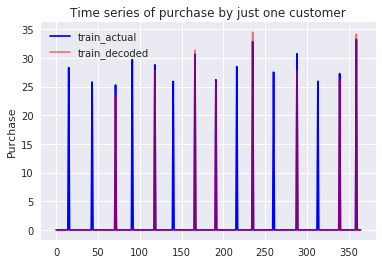

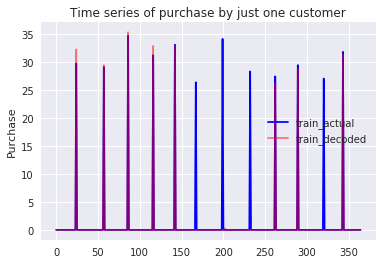

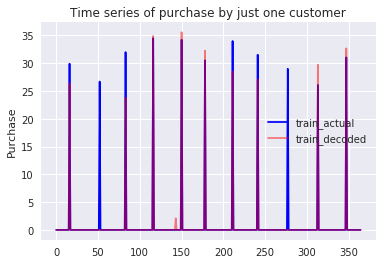

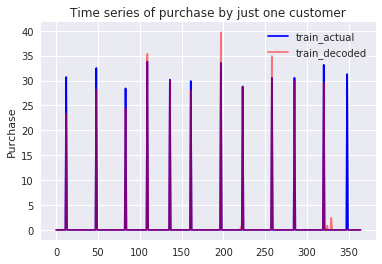

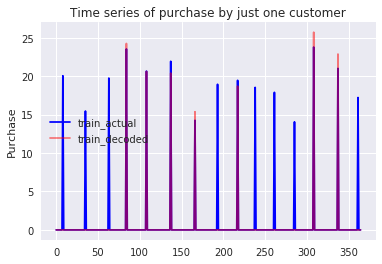

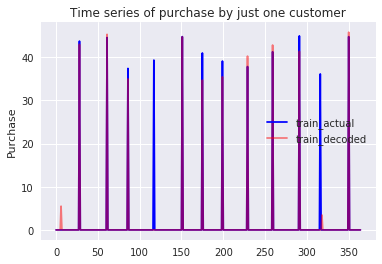

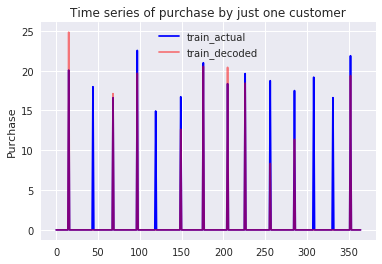

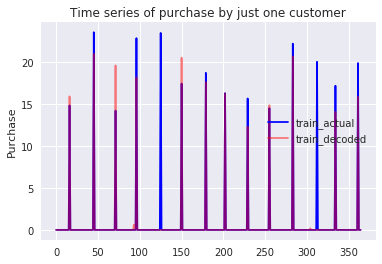

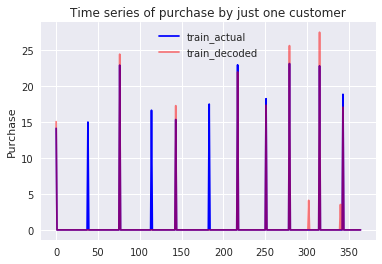

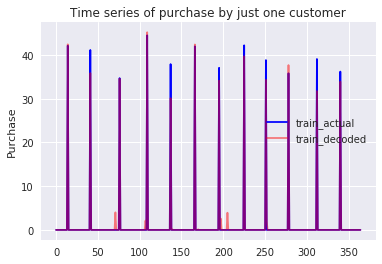

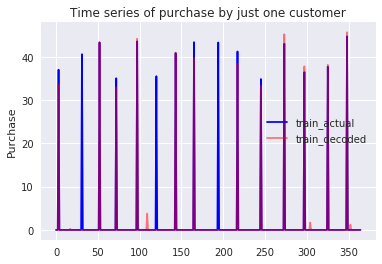

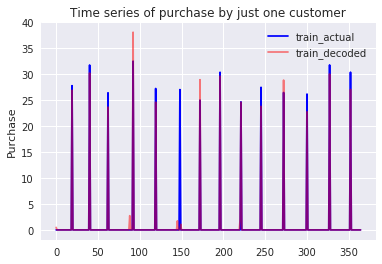

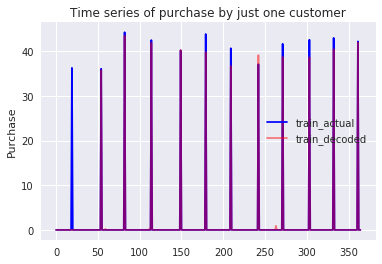

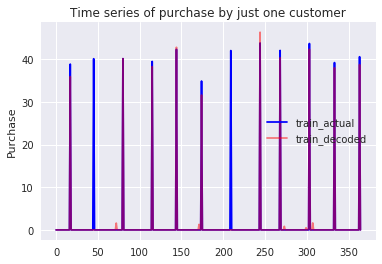

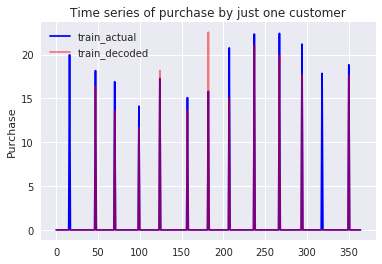

In [93]:
for i in list(xtrain.index[:25]):
    plt.title('Time series of purchase by just one customer')
    plt.plot(xtrain.loc[i,:], color = 'blue', label = 'train_actual')
    plt.plot(comparison.loc[i,:], color = 'red', label = 'train_decoded', alpha=0.5)
    plt.legend(loc='best')
    plt.ylabel('Purchase')
    plt.show()

In [94]:
xtrain_t = xtrain.T

In [95]:
category_periodicity = int(input('Periodicity of the category of interest ='))

Periodicity of the category of interest =30


In [96]:
xtrain_t.columns

Index(['Donor_1', 'Donor_100', 'Donor_1000', 'Donor_1001', 'Donor_1002',
       'Donor_1003', 'Donor_1004', 'Donor_1006', 'Donor_1007', 'Donor_101',
       ...
       'Test_144', 'Test_1440', 'Test_1441', 'Test_1442', 'Test_1443',
       'Test_1444', 'Test_1445', 'Test_1446', 'Test_1447', 'Test_1448'],
      dtype='object', name='id', length=5000)

In [100]:
all_score = []
start = time.time()
validation_number = int(input("Enter the percentage validation number:"))
for test_customer in xtrain_t.columns[:1]:
    sample_series = []
    for i in range(7):
        sample_series.append(pd.DataFrame(xtrain_t[test_customer]))
    
    total_donor_pool = pd.DataFrame({test_customer:xtrain_t[test_customer]})
    
    for i,n in [[5,sample_series[0]], [20,sample_series[1]]]:
        for j in [[1,3], [4,7], [7,14]]:
            for k in [1, 0.8, 0.6]:
                for l in range(20):
                    n['Offset'] = pd.DataFrame({'Offset':[random.randint(j[0], j[1]) for x in range(len(n))]})
                    offset_data = n[n[test_customer] != 0]
                    offset_index = offset_data.sample(int(np.ceil(i*len(offset_data)/100))).index
                    new_customer = list(n[test_customer])
                    for m in offset_index:
                        sign = random.choice([-1, 1])
                        if sign == 1:
                            temp1 = n[test_customer][m].copy()
                            new_customer[m] = 0
                            new_customer[max((m-n.Offset[m]),0)] = temp1*(np.round(random.gauss(k,0.05),2))
                        else:
                            temp2 = n[test_customer][m].copy()
                            new_customer[m] = 0
                            new_customer[min((m+n.Offset[m]), 364)] = temp2*(np.round(random.gauss(k,0.05),2))
                    
                    n['customer-%s-%s-%s-%s-%s'%(l,k,i, j[0], j[1])] = pd.DataFrame({'customer-%s-%s-%s-%s-%s'%(l,k,i, j[0],j[1]):new_customer})

        total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))
    
    for i,n in [[40,sample_series[2]]]:
        for j in [[1,3]]:
            for k in [1,0.8,0.6]:
                for l in range(20):
                    n['Offset'] = pd.DataFrame({'Offset':[random.randint(j[0], j[1]) for x in range(len(n))]})
                    offset_data = n[n[test_customer] != 0]
                    offset_index = offset_data.sample(int(np.ceil(i*len(offset_data)/100))).index
                    new_customer = list(n[test_customer])
                    for m in offset_index:
                        sign = random.choice([-1, 1])
                        if sign == 1:
                            temp1 = n[test_customer][m].copy()
                            new_customer[m] = 0
                            new_customer[max((m-n.Offset[m]),0)] = temp1*(np.round(random.gauss(k,0.05),2))
                        else:
                            temp2 = n[test_customer][m].copy()
                            new_customer[m] = 0
                            new_customer[min((m+n.Offset[m]), 364)] = temp2*(np.round(random.gauss(k,0.05),2))
                    n['customer-%s-%s-%s-%s-%s'%(l,k,i, j[0], j[1])] = pd.DataFrame({'customer-%s-%s-%s-%s-%s'%(l,k,i, j[0],j[1]):new_customer})

        total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))
    
    for i,n in [[5, sample_series[5]]]:
        for j in [[1,3], [4,7], [7,14]]:
            for k in [1, 0.8, 0.6]:
                for c in range(20):
                    a = random.randint(j[0], j[1])
                    n['Offset'] = pd.DataFrame({'Offset':[a for x in range(len(n))]})
                    sign = random.choice([-1, 1])
                    offset_data = n[n[test_customer] != 0]
                    offset_index = offset_data.sample(int(np.ceil(random.randint(80,90)*len(offset_data)/100))).index
                    new_customer = list(n[test_customer])
                    for m in offset_index:
                        if sign == 1:
                            temp1 = n[test_customer][m].copy()
                            new_customer[m] = 0
                            new_customer[max((m-n.Offset[m]),0)] = temp1*(np.round(random.gauss(k,0.05),2))
                        else:
                            temp2 = n[test_customer][m].copy()
                            new_customer[m] = 0
                            new_customer[min((m+n.Offset[m]), 364)] = temp2*(np.round(random.gauss(k,0.05),2))
                    n['customer_con_off-%s-%s-%s-%s-%s'%(c,k,i, j[0], j[1])] = pd.DataFrame({'customer_con_off-%s-%s-%s-%s-%s'%(l,k,i, j[0],j[1]):new_customer})
        total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))
        
    for i,n in [[40,sample_series[6]]]:
        for j in [[4,7], [7,14]]:
            for k in [1, 0.8, 0.6]:
                for l in range(20):
                    n['Offset'] = pd.DataFrame({'Offset':[random.randint(j[0], j[1]) for x in range(len(n))]})
                    offset_data = n[n[test_customer] != 0]
                    offset_index = offset_data.sample(int(np.ceil(i*len(offset_data)/100))).index
                    new_customer = list(n[test_customer])
                    for m in offset_index:
                        sign = random.choice([-1, 1])
                        if sign == 1:
                            temp1 = n[test_customer][m].copy()
                            new_customer[m] = 0
                            new_customer[max((m-n.Offset[m]),0)] = temp1*(np.round(random.gauss(k,0.05),2))
                        else:
                            temp2 = n[test_customer][m].copy()
                            new_customer[m] = 0
                            new_customer[min((m+n.Offset[m]), 364)] = temp2*(np.round(random.gauss(k,0.05),2))
                    n['customer-%s-%s-%s-%s-%s'%(l,k,i, j[0], j[1])] = pd.DataFrame({'customer-%s-%s-%s-%s-%s'%(l,k,i, j[0],j[1]):new_customer})

        total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))
        
    for i,n in [[60,sample_series[3]], [80, sample_series[4]]]:
        for j in [[1,3], [4,7], [7,14]]:
            for k in [1,0.8,0.6]:
                for l in range(20):
                    n['Offset'] = pd.DataFrame({'Offset':[random.randint(j[0], j[1]) for x in range(len(n))]})
                    offset_data = n[n[test_customer] != 0]
                    offset_index = offset_data.sample(int(np.ceil(i*len(offset_data)/100))).index
                    new_customer = list(n[test_customer])
                    for m in offset_index:
                        sign = random.choice([-1, 1])
                        if sign == 1:
                            temp1 = n[test_customer][m].copy()
                            new_customer[m] = 0
                            new_customer[max((m-n.Offset[m]),0)] = temp1*(np.round(random.gauss(k,0.05),2))
                        else:
                            temp2 = n[test_customer][m].copy()
                            new_customer[m] = 0
                            new_customer[min((m+n.Offset[m]), 364)] = temp2*(np.round(random.gauss(k,0.05),2))
                    n['customer-%s-%s-%s-%s-%s'%(l,k,i, j[0], j[1])] = pd.DataFrame({'customer-%s-%s-%s-%s-%s'%(l,k,i, j[0],j[1]):new_customer})

        total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))
    
    all_donors = total_donor_pool.T.values
    encoding = encoder.predict(all_donors)
    
    encoding_df = pd.DataFrame(encoding)
    encoding_df.insert(loc=0, column='id', value=total_donor_pool.columns.values)
    encoding_df = encoding_df.set_index(encoding_df.id).drop(labels = ['id'], axis = 1)
    encoding_df.head()
    
    score = []
    for i in range(len(encoding_df)):
        score.append(scipy.spatial.distance.euclidean(encoding_df.iloc[0,:], encoding_df.iloc[i,:]))
    
    distance = pd.DataFrame({'distance':score}, index = encoding_df.index)
    encoding_df = encoding_df.join(distance).sort_values(by='distance', ascending=True)
    
    
    final_donor_pool = encoding_df.T.columns[:int(validation_number*len(encoding_df.T.columns)/100)]
    initial_donor_pool = total_donor_pool.columns[:int(validation_number*len(encoding_df.T.columns)/100)]
    
    similarity = 0
    for i in final_donor_pool:
        if i in initial_donor_pool:
            similarity+=1
        else:
            similarity+=0
    
    all_score.append(np.round(similarity/len(initial_donor_pool),2)*100)
    
print('Creation time =', (time.time()-start)/60, 'minutes')    
print('Mean score =', np.mean(all_score))
all_score_df = pd.DataFrame({'Customer':xtrain_t.columns[:1], 'score':all_score})

Enter the percentage validation number:50
Creation time = 0.12362053394317626 minutes
Mean score = 77.0


In [101]:
pd.set_option('display.max_rows', None)